# Importing libraries

In [ ]:
pip install -r requirements.txt

In [ ]:
import qprepfn
import numpy as np

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


# Represent a function as MPS

In [ ]:
# In this example we want to prepare a gaussian function with expected value 0.5 and variance 0.01 

f = lambda x: np.exp(-(x-0.5)**2/(2*0.01))/np.sqrt(2*np.pi*0.01)

In [ ]:
# First of all, we choose the number of qubits in the quantum state of which we will write this function

n = 10 # 2**n - the number of sampling points

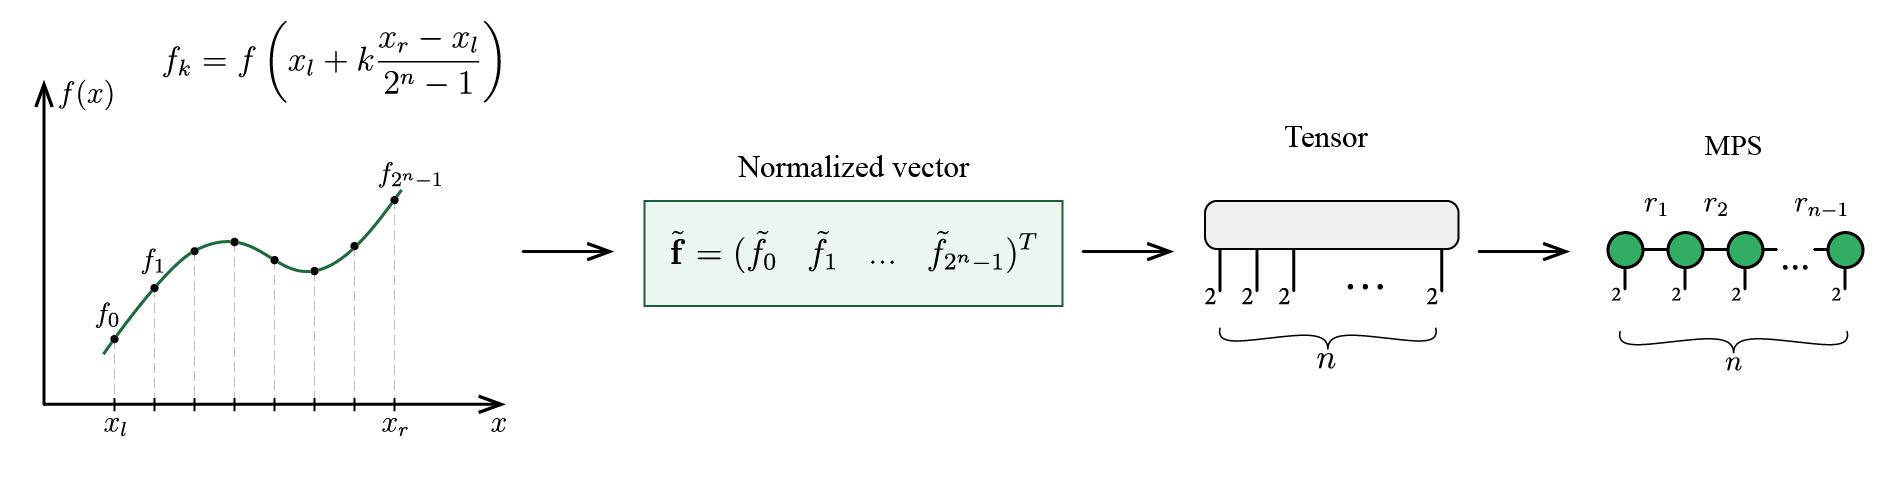

In [ ]:
# Now get the MPS from the function f(x)

# [0,b] - an interval over which discretize the function
b = 1
h = b/(2**n-1) # sampling step

x = h * qprepfn.tt.xfun(2,n) # MPS form of a function z(x) = x
  
psi_tt = qprepfn.tt.multifuncrs([x], f , eps = 10**(-8), rmax= 10 , verb = False) # Approximation f(x) in terms of MPS

In [ ]:
# Normalization 
norm = psi_tt.norm()
psi_tt = psi_tt * (1 / norm)

# Find a circuit

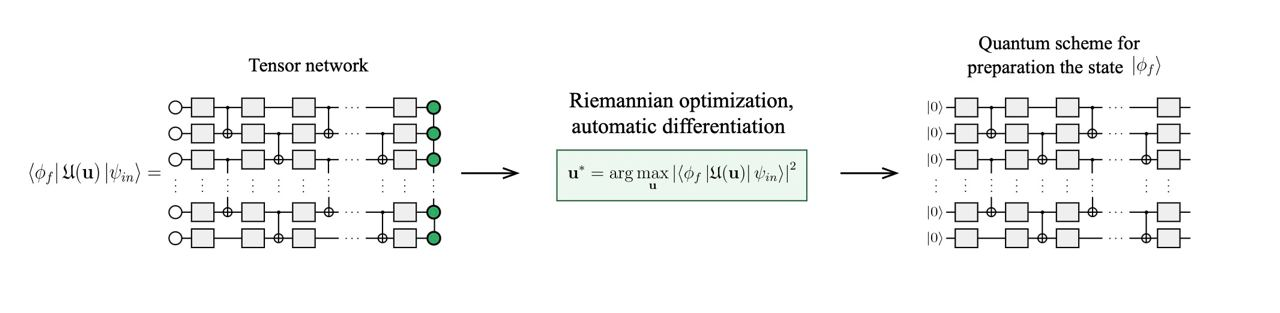

In [ ]:
# Choose the number of layers in the scheme that will be optimized
Layers = 3

At the last iteration, 1 - fidelity =  0.00525325053819703


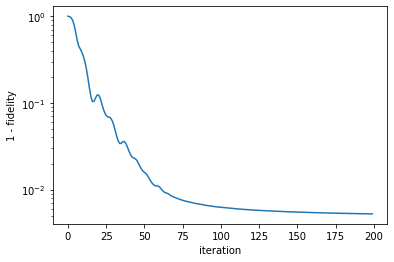

In [ ]:
# Do 200 iterations of Riemannian Adam optimization 
#                      with optimization step size 0.05 and standard other hyperparameters
#                      (\beta_1 = 0.9, \beta_2 = 0.999, \epsilon = 10**(-8))
# For TN contraction use "greedy" algorithm
# Plot dependence of the error on the iteration number
qc, U = qprepfn.qiskit_circuit_from_tt(psi_tt, n, Layers, iters=200)

# Circuit vizualization/simulation

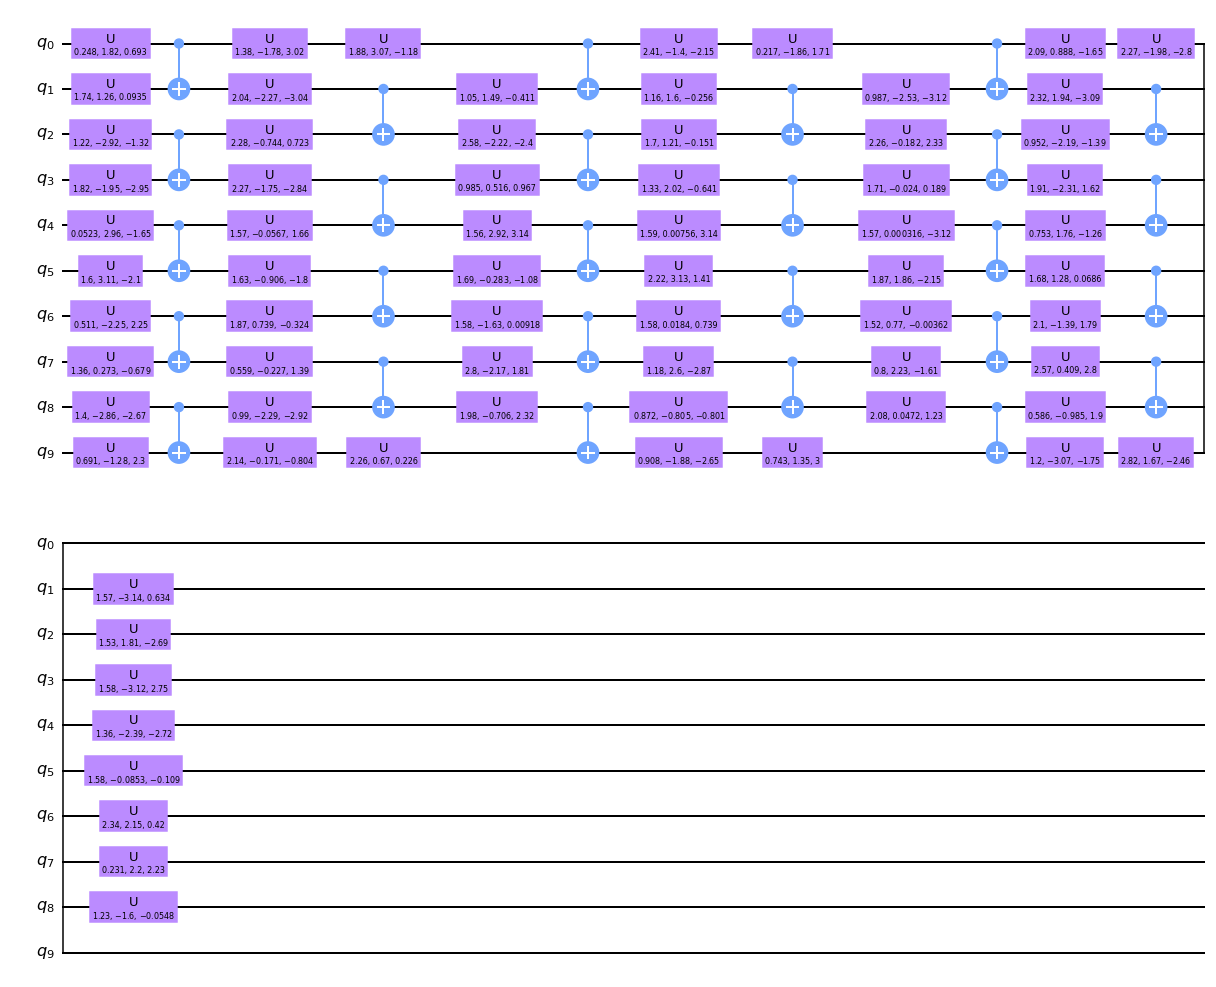

In [ ]:
# Draw obtained quantum circuit
qc.draw('mpl')

In [ ]:
# Simulate the action of the resultimg quantum circuit

from qiskit.quantum_info import Statevector

# Set the intial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**n)

# Evolve the state by the quantum circuit
state = state.evolve(qc)

state.draw('latex')

<IPython.core.display.Latex object>

Text(0, 0.5, '$f(x)$')

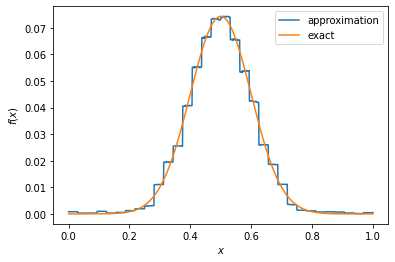

In [ ]:
# Visualize the resulting function and the target one

qprepfn.plt.plot(np.arange(0,2**n)*h, np.abs(state.data), label = "approximation")
qprepfn.plt.plot(np.arange(0,2**n)*h, psi_tt.full().reshape(2**n, order = 'F'), label = "exact" )
qprepfn.plt.legend()
qprepfn.plt.xlabel('$x$')
qprepfn.plt.ylabel('$f(x)$')

# Find better contraction sequence

In [ ]:
# Now use CoTenGra for TN contraction
# Find the optimal TN contraction path minimizing 

peo_tree = qprepfn.get_peo_rand(n,Layers,psi_tt)

# Print the contraction width W, is log2 the size of the largest intermediate tensor
print('\n\nContraction width = ', peo_tree[1].contraction_width())

# Print the contraction cost C, is the total number os scalar multiplications
print('Contraction cost = ', peo_tree[1].contraction_cost())

log2[SIZE]: 7.58 log10[FLOPs]: 4.39: 100%|██████████| 64/64 [00:06<00:00, 10.62it/s]


 Contraction width =  7.584962500721156
Contraction cost =  12360.0


At the last iteration, 1 - fidelity =  0.004204709252882299


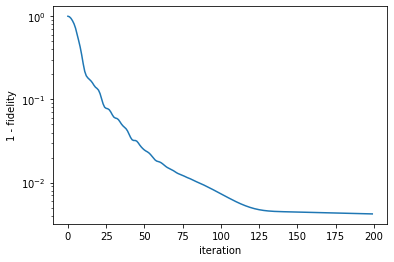

In [ ]:
# Do 200 iterations of Riemannian optimization with the same hyperparameters but
# for TN contraction use the previously obtained contraction path

qc1, U1 = qprepfn.qiskit_circuit_from_tt(psi_tt, n, Layers, iters=200,contr='cotengra',peo_tree=peo_tree)

Text(0, 0.5, '$f(x)$')

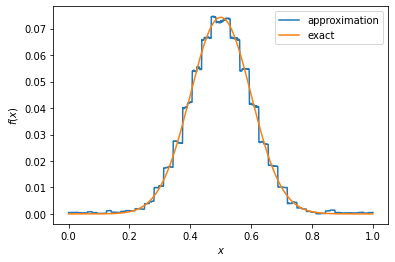

In [ ]:
# Simulate the action of the resultimg quantum circuit
state1 = Statevector.from_int(0, 2**n)
state1 = state1.evolve(qc1)

# Visualize the resulting function and the target one

qprepfn.plt.plot(np.arange(0,2**n)*h, np.abs(state1.data), label = "approximation")
qprepfn.plt.plot(np.arange(0,2**n)*h, psi_tt.full().reshape(2**n, order = 'F'), label = "exact" )
qprepfn.plt.legend()
qprepfn.plt.xlabel('$x$')
qprepfn.plt.ylabel('$f(x)$')

# Barren plateaus

In [ ]:
# Now get the MPS from the function f(x) for 100 qubits

n = 100
x = h * qprepfn.tt.xfun(2,n)  
psi_tt = qprepfn.tt.multifuncrs([x], f , eps = 10**(-8), rmax= 10 , verb = False) # Approximation f(x) in terms of MPS

# Normalization 
norm = psi_tt.norm()
psi_tt = psi_tt * (1 / norm)

In [ ]:
# Choose the number of layers
Layers = 3

At the last iteration, 1 - fidelity =  1.0


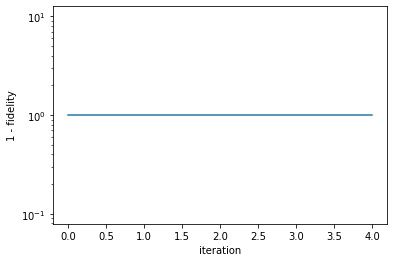

In [ ]:
# With a large number of qubits, the gradients become too small and optimization is not possible
# if the starting point of optimization is chosen randomly
qc, U = qprepfn.qiskit_circuit_from_tt(psi_tt, n, Layers, iters=5)

In [ ]:
# Divide the MPS into M parts
M = 2
MPSs = qprepfn.divide_mps(psi_tt,n,M)

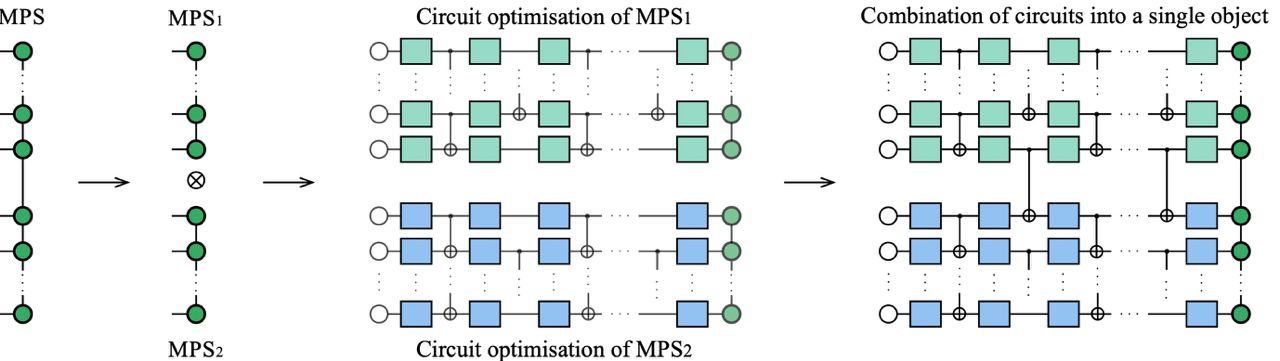

In [ ]:
# For each MPS from MPSs, we slightly optimize the scheme (iters - the number of iterations) and write the resulting one-qubit gates
# prints errors after the last iteration for each MPS
Us = qprepfn.get_initial_point(MPSs,n,Layers,iters=20,print_errs=True)

[0.7350184744747508, 0.43693915828431307]


At the last iteration, 1 - fidelity =  0.003677317765672372


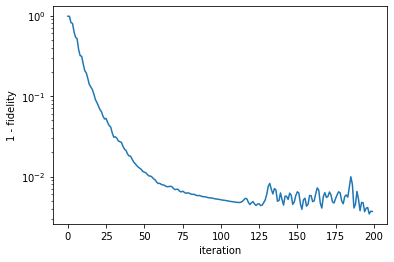

In [ ]:
# Now we collect the initial approximation for the entire circuit from the M resulting pieces and run
U00 = qprepfn.tf.concat(Us,1)
qc, U = qprepfn.qiskit_circuit_from_tt(psi_tt, n, Layers, U0 = U00, iters=200)